# The Joy of Neural Painting (1/4)

[Neural Painters](https://arxiv.org/abs/1904.08410) [1] are a class of models that can be seen as a fully differentiable simulation of a particular non-differentiable painting program, in other words, the machine "paints" by successively generating brushstrokes (i.e., actions that defines a brushstrokes) and applying them on a canvas, as an artist would do.

---

[1] *Neural Painters: A Learned Differentiable Constraint for Generating Brushstroke Paintings*. Reiichiro Nakano. arXiv preprint [arXiv:1904.08410](https://arxiv.org/abs/1904.08410), 2019.

# Training the Generator Non-Adversarially

In this initial stage our goal is to pre-train the `Generator` using a non-adversarial `Feature Loss`. 

The `Generator` is defined as a [`Linear Layer`](https://pytorch.org/docs/stable/nn.html#linear) followed by a [`Deep Convolutional Neural Network`](https://docs.fast.ai/vision.gan.html#basic_generator)

`Feature Loss` based on the implementation introduced in 

* Fast.ai MOOC [Lesson 7: Resnets from scratch; U-net; Generative (adversarial) networks.](https://course.fast.ai/videos/?lesson=7). 

This loss is a variant of `Perceptual Losses` discussed in the paper:

* *Perceptual Losses for Real-Time Style Transfer and Super-Resolution*. Justin Johnson, Alexandre Alahi, Li Fei-Fei. https://arxiv.org/abs/1603.08155 , 2016

<center><img src="https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/neural_painter_generator_non_adversarial.jpg" width="50%"/></center>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF
import torch.optim as optim
import fastai
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import PIL
import os

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from glob import glob
from torchvision import models
from pathlib import Path
from IPython.display import display, clear_output

# from fastai.vision import *
from fastai.torch_core import requires_grad, children
from fastai.vision.gan import basic_generator, gan_critic
from fastai.callbacks import hook_outputs

print('torch.__version__', torch.__version__)


torch.__version__ 1.1.0


# Dataset

For the purposes of this excercise we will use a collection of 100K brushstrokes, that is a single `episodes` file from the full `neural-painters` dataset available in Kaggle: https://www.kaggle.com/reiinakano/mypaint_brushstrokes

We have made available the file using Google Drive: [episodes_42.npz](https://drive.google.com/a/libreai.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x&export=download). Given its size (196M) `wget` or `curl` will fail because of the security warning from Google Drive, we will therefore go with [gdwon](https://pypi.org/project/gdown/) to download it.

In [0]:
!pip install gdown

In [0]:
# create a folder called `data` and donwload the dataset there
!mkdir data; cd data; gdown https://drive.google.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x

Downloading...
From: https://drive.google.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x
To: /content/data/episodes_42.npz
206MB [00:01, 202MB/s] 


In [0]:
data_fname = 'episodes_42.npz'
loaded = np.load('data/' + data_fname)

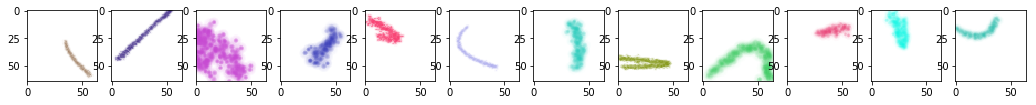

In [0]:
w=800
h=600

fig=plt.figure(figsize=(30, 10))
cols = 12

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [0]:
loaded['actions'][:cols]

array([[0.330522, 0.249296, 0.638134, 0.656268, ..., 0.38073 , 0.896127, 0.924754, 0.466711],
       [0.72314 , 0.260811, 0.776887, 0.059226, ..., 0.559846, 0.741848, 0.114233, 0.203668],
       [0.992721, 0.830709, 0.019449, 0.30396 , ..., 0.821641, 0.674657, 0.922126, 0.893378],
       [0.174172, 0.807182, 0.734837, 0.432679, ..., 0.718031, 0.459332, 0.69727 , 0.848882],
       ...,
       [0.234808, 0.834783, 0.7658  , 0.520075, ..., 0.341833, 0.937458, 0.986008, 0.497608],
       [0.295077, 0.680203, 0.709675, 0.272433, ..., 0.458307, 0.830108, 0.251563, 0.731567],
       [0.227581, 0.703463, 0.452308, 0.504263, ..., 0.88884 , 0.30347 , 0.054811, 0.541374],
       [0.41137 , 0.667527, 0.380177, 0.360587, ..., 0.664123, 0.001316, 0.249934, 0.20228 ]])

In [0]:
# a helper class to encapsulate some parameters
class Params():
    def __init__(self):
        super(Params)

In [0]:
params = Params()
params.condition_dim = 12
params.noise_dim = 0
params.image_size = 64
params.channels = 3
params.batch_size = 256
params.lr = 1e-3
params.train_epoch = 1
params.fc_dim = int(params.image_size * params.image_size)

# The Generator

The `Generator` is defined as a [`Linear Layer`](https://pytorch.org/docs/stable/nn.html#linear) followed by a [`Deep Convolutional Neural Network`](https://docs.fast.ai/vision.gan.html#basic_generator)

In [0]:
class GeneratorX(nn.Module):

    def __init__(self, condition_dim, fc_dim, in_size, n_channels, n_extra_layers):
        super(GeneratorX, self).__init__()
        self.fc = nn.Linear(condition_dim, fc_dim)
        self.generator = basic_generator(in_size=in_size, n_channels=n_channels, n_extra_layers=n_extra_layers, noise_sz=fc_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.generator(x.view(x.size(0), x.size(1), 1, 1))
        return x



In [0]:
generator = GeneratorX(condition_dim=params.condition_dim,
                fc_dim=params.fc_dim,
                in_size=params.image_size,
                n_channels=params.channels,
                n_extra_layers=1
               )

generator

GeneratorX(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, 

## The Feature Loss

Feature Loss based on the implementation introduced in 

* Fast.ai MOOC [Lesson 7: Resnets from scratch; U-net; Generative (adversarial) networks.](https://course.fast.ai/videos/?lesson=7). 

This loss is a variant of `Perceptual Losses` discussed in the paper:

* *Perceptual Losses for Real-Time Style Transfer and Super-Resolution*. Justin Johnson, Alexandre Alahi, Li Fei-Fei. https://arxiv.org/abs/1603.08155 , 2016

Using a VGG16 model as Feature Extractor

In [0]:
vgg_m = models.vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:10<00:00, 54757522.19it/s]


[5, 12, 22, 32, 42]

In [0]:
def gram_matrix(x):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features @ features_t / (ch * h * w)
    return gram

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, feature_extractor, layer_ids, layer_wgts):
        super(FeatureLoss, self).__init__()
        
        # using L1 as base for computing the loss
        self.base_loss = F.l1_loss 
        self.feature_extractor = feature_extractor
        self.loss_features = [self.feature_extractor[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts

    def make_features(self, x, clone=False):
        self.feature_extractor(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):

        input_features = self.make_features(input)
        target_features = self.make_features(target, clone=True)
        
        self.feat_losses = []
        
        self.feat_losses += [self.base_loss(f_in, f_out) * w
                             for f_in, f_out, w in zip(input_features, target_features, self.wgts)]
        

        self.feat_losses += [self.base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w**2 * 5e3
                             for f_in, f_out, w in zip(input_features, target_features, self.wgts)]
    
        self.feat_losses += [self.base_loss(input, target)]
                
        return sum(self.feat_losses)
    
    def __del__(self):
        self.hooks.remove()
        

In [0]:
feature_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [0]:
# moving generator to GPU
generator.cuda()

# Adam optimizer
optimizer = optim.Adam(generator.parameters(), lr=params.lr, betas=(0.5, 0.9))

In [0]:
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div_(255))
                                  ])

training start!
epoch 1
epoch 1/15 | 1/391 complete!
loss: 8.344079971313477
true


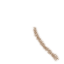

pred


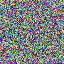

---
epoch 1/15 | 51/391 complete!
loss: 6.127547740936279
true


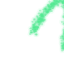

pred


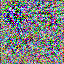

---
epoch 1/15 | 101/391 complete!
loss: 5.602797508239746
true


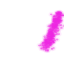

pred


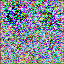

---
epoch 1/15 | 151/391 complete!
loss: 5.252739906311035
true


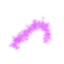

pred


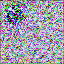

---
epoch 1/15 | 201/391 complete!
loss: 4.983636379241943
true


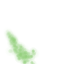

pred


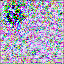

---
epoch 1/15 | 251/391 complete!
loss: 4.773161888122559
true


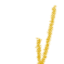

pred


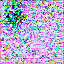

---
epoch 1/15 | 301/391 complete!
loss: 4.604804992675781
true


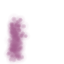

pred


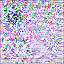

---
epoch 1/15 | 351/391 complete!
loss: 4.468193054199219
true


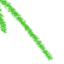

pred


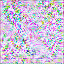

---
epoch 2
epoch 2/15 | 1/391 complete!
loss: 3.845606565475464
true


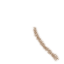

pred


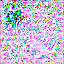

---
epoch 2/15 | 51/391 complete!
loss: 3.499868869781494
true


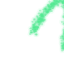

pred


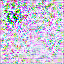

---
epoch 2/15 | 101/391 complete!
loss: 3.4579317569732666
true


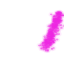

pred


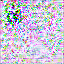

---
epoch 2/15 | 151/391 complete!
loss: 3.4210715293884277
true


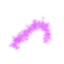

pred


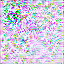

---
epoch 2/15 | 201/391 complete!
loss: 3.39056134223938
true


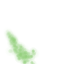

pred


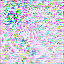

---
epoch 2/15 | 251/391 complete!
loss: 3.362748861312866
true


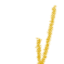

pred


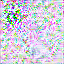

---
epoch 2/15 | 301/391 complete!
loss: 3.33901309967041
true


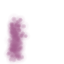

pred


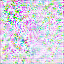

---
epoch 2/15 | 351/391 complete!
loss: 3.313774347305298
true


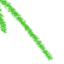

pred


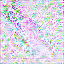

---
epoch 3
epoch 3/15 | 1/391 complete!
loss: 3.126225471496582
true


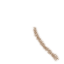

pred


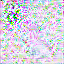

---
epoch 3/15 | 51/391 complete!
loss: 3.094775915145874
true


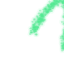

pred


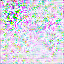

---
epoch 3/15 | 101/391 complete!
loss: 3.0773403644561768
true


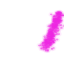

pred


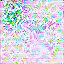

---
epoch 3/15 | 151/391 complete!
loss: 3.058769464492798
true


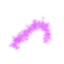

pred


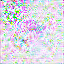

---
epoch 3/15 | 201/391 complete!
loss: 3.03896164894104
true


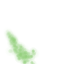

pred


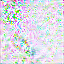

---
epoch 3/15 | 251/391 complete!
loss: 3.0178263187408447
true


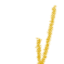

pred


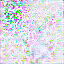

---
epoch 3/15 | 301/391 complete!
loss: 2.9982171058654785
true


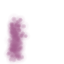

pred


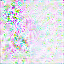

---
epoch 3/15 | 351/391 complete!
loss: 2.976402521133423
true


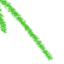

pred


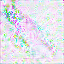

---
epoch 4
epoch 4/15 | 1/391 complete!
loss: 2.711427688598633
true


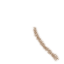

pred


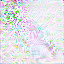

---
epoch 4/15 | 51/391 complete!
loss: 2.7515974044799805
true


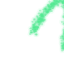

pred


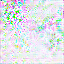

---
epoch 4/15 | 101/391 complete!
loss: 2.720355749130249
true


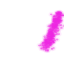

pred


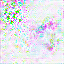

---
epoch 4/15 | 151/391 complete!
loss: 2.6786270141601562
true


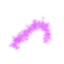

pred


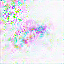

---
epoch 4/15 | 201/391 complete!
loss: 2.6366357803344727
true


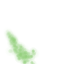

pred


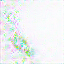

---
epoch 4/15 | 251/391 complete!
loss: 2.5953004360198975
true


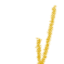

pred


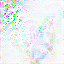

---
epoch 4/15 | 301/391 complete!
loss: 2.5509841442108154
true


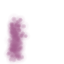

pred


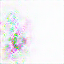

---
epoch 4/15 | 351/391 complete!
loss: 2.5042288303375244
true


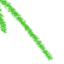

pred


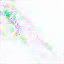

---
epoch 5
epoch 5/15 | 1/391 complete!
loss: 2.0485992431640625
true


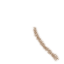

pred


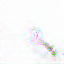

---
epoch 5/15 | 51/391 complete!
loss: 2.011090040206909
true


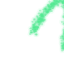

pred


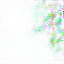

---
epoch 5/15 | 101/391 complete!
loss: 1.9751981496810913
true


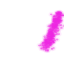

pred


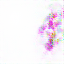

---
epoch 5/15 | 151/391 complete!
loss: 1.9476771354675293
true


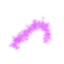

pred


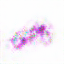

---
epoch 5/15 | 201/391 complete!
loss: 1.9247663021087646
true


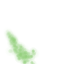

pred


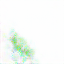

---
epoch 5/15 | 251/391 complete!
loss: 1.9062047004699707
true


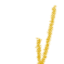

pred


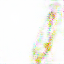

---
epoch 5/15 | 301/391 complete!
loss: 1.8874115943908691
true


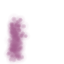

pred


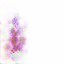

---
epoch 5/15 | 351/391 complete!
loss: 1.8686307668685913
true


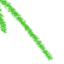

pred


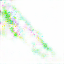

---
epoch 6
epoch 6/15 | 1/391 complete!
loss: 1.7247422933578491
true


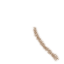

pred


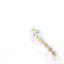

---
epoch 6/15 | 51/391 complete!
loss: 1.7100226879119873
true


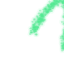

pred


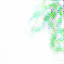

---
epoch 6/15 | 101/391 complete!
loss: 1.695513129234314
true


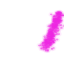

pred


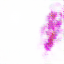

---
epoch 6/15 | 151/391 complete!
loss: 1.683172583580017
true


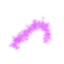

pred


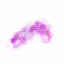

---
epoch 6/15 | 201/391 complete!
loss: 1.6721546649932861
true


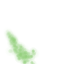

pred


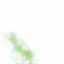

---
epoch 6/15 | 251/391 complete!
loss: 1.661314845085144
true


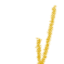

pred


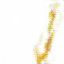

---
epoch 6/15 | 301/391 complete!
loss: 1.6499141454696655
true


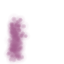

pred


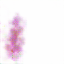

---
epoch 6/15 | 351/391 complete!
loss: 1.6371065378189087
true


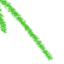

pred


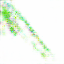

---
epoch 7
epoch 7/15 | 1/391 complete!
loss: 1.536877155303955
true


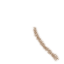

pred


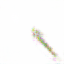

---
epoch 7/15 | 51/391 complete!
loss: 1.529311180114746
true


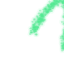

pred


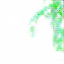

---
epoch 7/15 | 101/391 complete!
loss: 1.5182421207427979
true


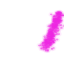

pred


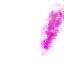

---
epoch 7/15 | 151/391 complete!
loss: 1.5092689990997314
true


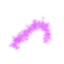

pred


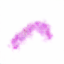

---
epoch 7/15 | 201/391 complete!
loss: 1.5006166696548462
true


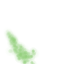

pred


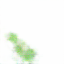

---
epoch 7/15 | 251/391 complete!
loss: 1.4935036897659302
true


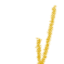

pred


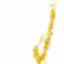

---
epoch 7/15 | 301/391 complete!
loss: 1.484602928161621
true


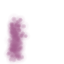

pred


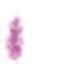

---
epoch 7/15 | 351/391 complete!
loss: 1.474135398864746
true


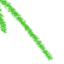

pred


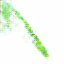

---
epoch 8
epoch 8/15 | 1/391 complete!
loss: 1.4423716068267822
true


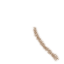

pred


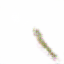

---
epoch 8/15 | 51/391 complete!
loss: 1.3958312273025513
true


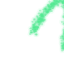

pred


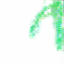

---
epoch 8/15 | 101/391 complete!
loss: 1.3869340419769287
true


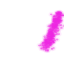

pred


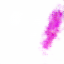

---
epoch 8/15 | 151/391 complete!
loss: 1.3796731233596802
true


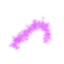

pred


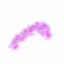

---
epoch 8/15 | 201/391 complete!
loss: 1.374775767326355
true


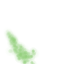

pred


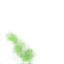

---
epoch 8/15 | 251/391 complete!
loss: 1.369720220565796
true


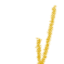

pred


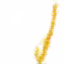

---
epoch 8/15 | 301/391 complete!
loss: 1.363741397857666
true


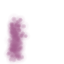

pred


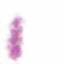

---
epoch 8/15 | 351/391 complete!
loss: 1.35637629032135
true


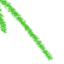

pred


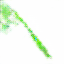

---
epoch 9
epoch 9/15 | 1/391 complete!
loss: 1.3500959873199463
true


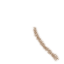

pred


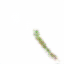

---
epoch 9/15 | 51/391 complete!
loss: 1.3029102087020874
true


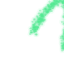

pred


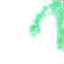

---
epoch 9/15 | 101/391 complete!
loss: 1.296349048614502
true


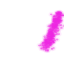

pred


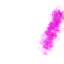

---
epoch 9/15 | 151/391 complete!
loss: 1.2903192043304443
true


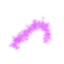

pred


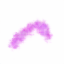

---
epoch 9/15 | 201/391 complete!
loss: 1.287781834602356
true


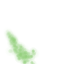

pred


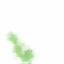

---
epoch 9/15 | 251/391 complete!
loss: 1.2856264114379883
true


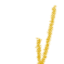

pred


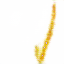

---
epoch 9/15 | 301/391 complete!
loss: 1.281821370124817
true


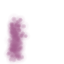

pred


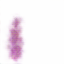

---
epoch 9/15 | 351/391 complete!
loss: 1.2762523889541626
true


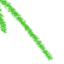

pred


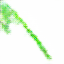

---
epoch 10
epoch 10/15 | 1/391 complete!
loss: 1.3002538681030273
true


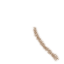

pred


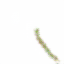

---
epoch 10/15 | 51/391 complete!
loss: 1.2382575273513794
true


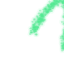

pred


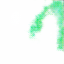

---
epoch 10/15 | 101/391 complete!
loss: 1.2327641248703003
true


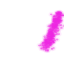

pred


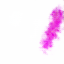

---
epoch 10/15 | 151/391 complete!
loss: 1.2286020517349243
true


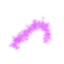

pred


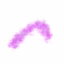

---
epoch 10/15 | 201/391 complete!
loss: 1.228055715560913
true


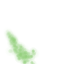

pred


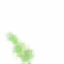

---
epoch 10/15 | 251/391 complete!
loss: 1.2267307043075562
true


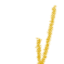

pred


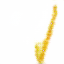

---
epoch 10/15 | 301/391 complete!
loss: 1.2242976427078247
true


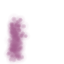

pred


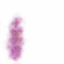

---
epoch 10/15 | 351/391 complete!
loss: 1.219494104385376
true


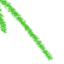

pred


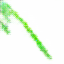

---
epoch 11
epoch 11/15 | 1/391 complete!
loss: 1.2603082656860352
true


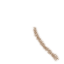

pred


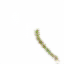

---
epoch 11/15 | 51/391 complete!
loss: 1.1943838596343994
true


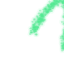

pred


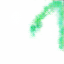

---
epoch 11/15 | 101/391 complete!
loss: 1.1893813610076904
true


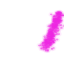

pred


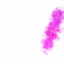

---
epoch 11/15 | 151/391 complete!
loss: 1.1849945783615112
true


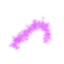

pred


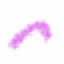

---
epoch 11/15 | 201/391 complete!
loss: 1.1850913763046265
true


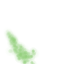

pred


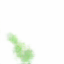

---
epoch 11/15 | 251/391 complete!
loss: 1.1844310760498047
true


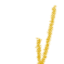

pred


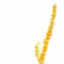

---
epoch 11/15 | 301/391 complete!
loss: 1.182325839996338
true


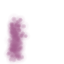

pred


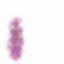

---
epoch 11/15 | 351/391 complete!
loss: 1.1787034273147583
true


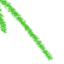

pred


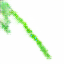

---
epoch 12
epoch 12/15 | 1/391 complete!
loss: 1.1985305547714233
true


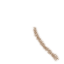

pred


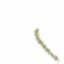

---
epoch 12/15 | 51/391 complete!
loss: 1.1575279235839844
true


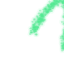

pred


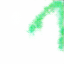

---
epoch 12/15 | 101/391 complete!
loss: 1.1529195308685303
true


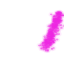

pred


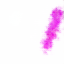

---
epoch 12/15 | 151/391 complete!
loss: 1.1496301889419556
true


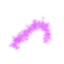

pred


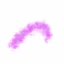

---
epoch 12/15 | 201/391 complete!
loss: 1.1498411893844604
true


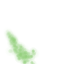

pred


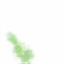

---
epoch 12/15 | 251/391 complete!
loss: 1.1500343084335327
true


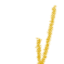

pred


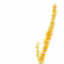

---
epoch 12/15 | 301/391 complete!
loss: 1.1483571529388428
true


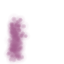

pred


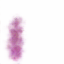

---
epoch 12/15 | 351/391 complete!
loss: 1.1444780826568604
true


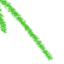

pred


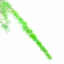

---
epoch 13
epoch 13/15 | 1/391 complete!
loss: 1.1922101974487305
true


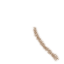

pred


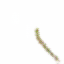

---
epoch 13/15 | 51/391 complete!
loss: 1.1290059089660645
true


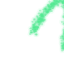

pred


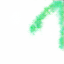

---
epoch 13/15 | 101/391 complete!
loss: 1.1248122453689575
true


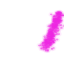

pred


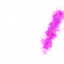

---
epoch 13/15 | 151/391 complete!
loss: 1.1213600635528564
true


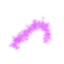

pred


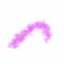

---
epoch 13/15 | 201/391 complete!
loss: 1.1220057010650635
true


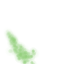

pred


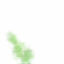

---
epoch 13/15 | 251/391 complete!
loss: 1.1219685077667236
true


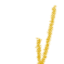

pred


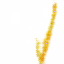

---
epoch 13/15 | 301/391 complete!
loss: 1.1210194826126099
true


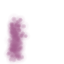

pred


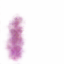

---
epoch 13/15 | 351/391 complete!
loss: 1.1179203987121582
true


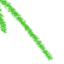

pred


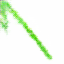

---
epoch 14
epoch 14/15 | 1/391 complete!
loss: 1.1664254665374756
true


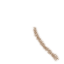

pred


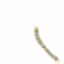

---
epoch 14/15 | 51/391 complete!
loss: 1.1011244058609009
true


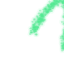

pred


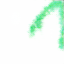

---
epoch 14/15 | 101/391 complete!
loss: 1.0987956523895264
true


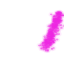

pred


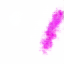

---
epoch 14/15 | 151/391 complete!
loss: 1.0965827703475952
true


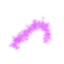

pred


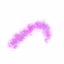

---
epoch 14/15 | 201/391 complete!
loss: 1.0978302955627441
true


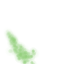

pred


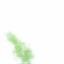

---
epoch 14/15 | 251/391 complete!
loss: 1.0979429483413696
true


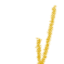

pred


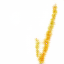

---
epoch 14/15 | 301/391 complete!
loss: 1.0972962379455566
true


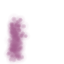

pred


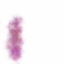

---
epoch 14/15 | 351/391 complete!
loss: 1.0945109128952026
true


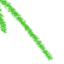

pred


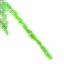

---
epoch 15
epoch 15/15 | 1/391 complete!
loss: 1.1440681219100952
true


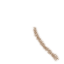

pred


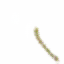

---
epoch 15/15 | 51/391 complete!
loss: 1.081538200378418
true


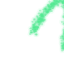

pred


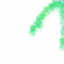

---
epoch 15/15 | 101/391 complete!
loss: 1.0791971683502197
true


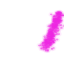

pred


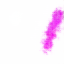

---
epoch 15/15 | 151/391 complete!
loss: 1.0760923624038696
true


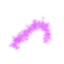

pred


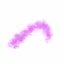

---
epoch 15/15 | 201/391 complete!
loss: 1.077176570892334
true


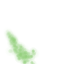

pred


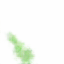

---
epoch 15/15 | 251/391 complete!
loss: 1.077842354774475
true


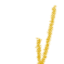

pred


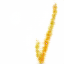

---
epoch 15/15 | 301/391 complete!
loss: 1.0772204399108887
true


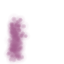

pred


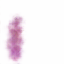

---
epoch 15/15 | 351/391 complete!
loss: 1.0745317935943604
true


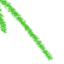

pred


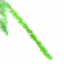

---
saving the Generator ... 
done.


In [0]:
params.train_epoch = 15

root = 'models/'
model = 'neural_painter_x_'
if not os.path.isdir(root):
    os.mkdir(root)
    
train_hist = {}
train_hist['losses'] = []


print('training start!')
start_time = time.time()

strokes = loaded['strokes']
conditions = loaded['actions']

strokes = torch.stack([torch.from_numpy(s).permute(2, 0, 1) for s in strokes])
conditions = torch.stack([torch.from_numpy(c).float() for c in conditions])

dataset = TensorDataset(strokes, conditions)
dataloader = DataLoader(dataset, batch_size=params.batch_size, shuffle=False)


for epoch in range(params.train_epoch):
  
  print('epoch {}'.format(epoch + 1))
  
  epoch_start_time = time.time()
  
  losses = []

  for num_iter, (stroke, condition) in enumerate(dataloader):  
    condition = condition.cuda()
    stroke = torch.stack([strokes_tfms(s) for s in stroke]).cuda()

    # -----------------
    #  Train Generator
    # -----------------
    optimizer.zero_grad()

    G_result = generator(condition)

    G_train_loss = feature_loss(G_result, stroke)

    G_train_loss.backward()
    optimizer.step()

    losses.append(G_train_loss.data.item())

    if (num_iter % 50) == 0:
        print('epoch {}/{} | {}/{} complete!'.format((epoch + 1), 
                                                     params.train_epoch,
                                                     (num_iter+1),
                                                     len(dataloader)))
        
        print('loss: {}'.format(torch.mean(torch.FloatTensor(losses))))
        # ---
        s = stroke[0].clone().cpu()
        print('true')
        display(VF.to_pil_image(s))
        # ---
        g = G_result[0].clone().cpu()
        print('pred')
        display(VF.to_pil_image(g))
        print('---')
  
print('saving the Generator ... ')
torch.save(generator.state_dict(), root + model + 'non_adversarial_' + 'generator_param.pth')
print('done.')


**We save the pre-trained Generator and proceed to train the Critic as a Binary Classifier with the Generator's weights frozen.**

### ~ Fin of this Part ~

---